In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None
style="darkgrid"
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.rcParams.update({'font.size': 12})

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ziid_cuo because the default path (/home/nik/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Simple ARFF parser
#### This is a utility function to load the dataset and store it as pandas dataframe.

In [2]:
def load_arff(filename):
    """
        Description
        ------------
        The purpose of this function is to parse the provided file and store the contents as a dataframe.

        @param filename <str>: the path and name of the file to parse

        @return <DataFrame>: a dataframe containing the data and the attribute names
    """
    
    attributes = []
    data = []
    
    try:
        # Open file with read rights
        with open(filename, 'r') as file_handle:
            
            # Read and store every line of the file
            contents = file_handle.readlines()
            
            # Iterate over all lines
            for line in contents:
                
                # Lines with the percentage symbol
                # need to be skipped 
                if line.startswith('%'):
                    continue
                    
                # We know that this should
                # be treated as an attribute
                if line.startswith('@attribute'):
                    # Split on every space
                    tokens = line.split(' ')
                    # Store only the attribute's name
                    attributes.append(tokens[1])
                else:
                    # Split on every , and
                    # also replace the \n character
                    tokens = line.strip().split(',')
                    # Keep only the elements that are not empty
                    if tokens[0]:
                        data.append(tokens)
                        
        # Discard the @relation, @data elements
        data = data[2:]
        
    except IOError as io_error:
        # Print the appropriate loading error and exit with code 1
        print("[!!] Unable to load {} --> reason: {}".format(filename, io_error))
    
    return pd.DataFrame(data, columns=attributes)

## Load the data

In [3]:
data = load_arff('Airlines.arff')

## Peek at the data

In [4]:
data.head()

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,UA,899.0,ORD,IAD,-3
1,5,615,DL,357.0,IAD,ATL,5
2,5,615,UA,341.0,IAD,DEN,8
3,5,625,CO,581.0,IAD,DEN,44
4,5,630,UA,902.0,CLE,IAD,-10


## Data dimensions

In [5]:
print('Numerosity: {}'.format(data.shape[0]))
print('Dimensionality: {}'.format(data.shape[1]))

Numerosity: 100161
Dimensionality: 7


## Data types, Non-Null values & Memory consumption

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100161 entries, 0 to 100160
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   DayofWeek      100161 non-null  object
 1   CRSDepTime     100161 non-null  object
 2   UniqueCarrier  100161 non-null  object
 3   FlightNum      100161 non-null  object
 4   Origin         100161 non-null  object
 5   Dest           100161 non-null  object
 6   ArrDelay       100161 non-null  object
dtypes: object(7)
memory usage: 5.3+ MB


## Type casting

In [7]:
integer_cols = ['DayofWeek', 'CRSDepTime', 'FlightNum', 'ArrDelay']

for ic in integer_cols:
    data[ic] = data[ic].astype(float).astype(int)

## Numeric columns description

In [8]:
data.describe()

,DayofWeek,CRSDepTime,FlightNum,ArrDelay
count,100161.000000,100161.000000,100161.000000,100161.000000
mean,3.952626,1357.918262,896.152654,4.638462
std,1.985074,460.022924,476.977517,23.397863
min,1.000000,5.000000,12.000000,-72.000000
25%,2.000000,925.000000,539.000000,-7.000000
50%,4.000000,1335.000000,1000.000000,0.000000
75%,6.000000,1735.000000,1264.000000,9.000000
max,7.000000,2359.000000,4007.000000,667.000000


## Categorical columns description

In [9]:
cat_cols = ['UniqueCarrier', 'Origin', 'Dest']
data[cat_cols].describe()

,UniqueCarrier,Origin,Dest
count,100161,100161,100161
unique,9,58,59
top,UA,IAD,IAD
freq,63706,50229,49932


## Feature distribution
#### Day of week distribution
##### The data of this column are similar to a uniform distribution; hence do not provide us with very useful information.

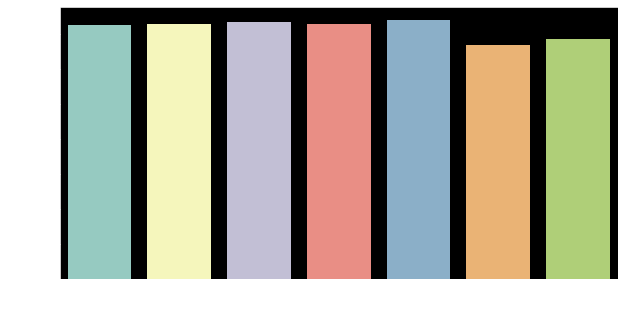

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='DayofWeek')
plt.show()

#### Scheduled departure time distribution and comparison with arrival delays.
##### In the first plot, the distribution of the scheduled departure (CRSDepTime) resembles a multimodal Gaussian distribution, with different means and similar standard deviations for each mode. 
##### In the second plot the scheduled departure time is illustrated against the associated delay, where we can observe that for departures around 11:00 there is a spike in the delays.

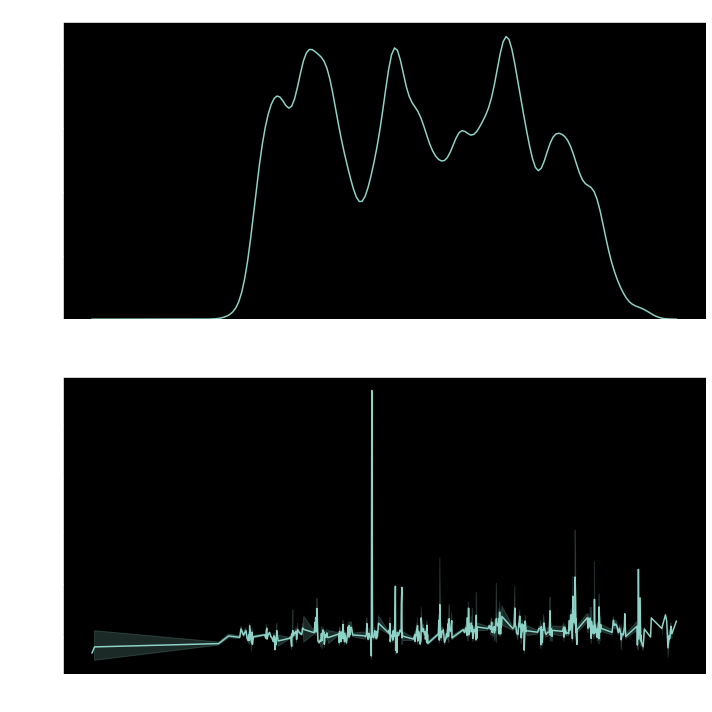

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].set_title('Scheduled Departure Time Distribution')
sns.kdeplot(ax=axes[0], data=data, x='CRSDepTime')
axes[1].set_title('Scheduled Departure Time - Arrival Delays')
sns.lineplot(ax=axes[1], data=data, x='CRSDepTime', y='ArrDelay')
plt.tight_layout()
plt.show()

#### Flight number distribution and comparison with delays
##### First plot: flight number data follow a multimodal Gaussian distribution with most values around the 1000-1100 interval.
##### Second plot: flight number data show the greatest spikes in delays in the [0, 500] interval. This could mean that delays and flight numbers are associated, but it is more likely that flight numbers are correlated with other features such as CRSDepTime and hence display this behaviour.

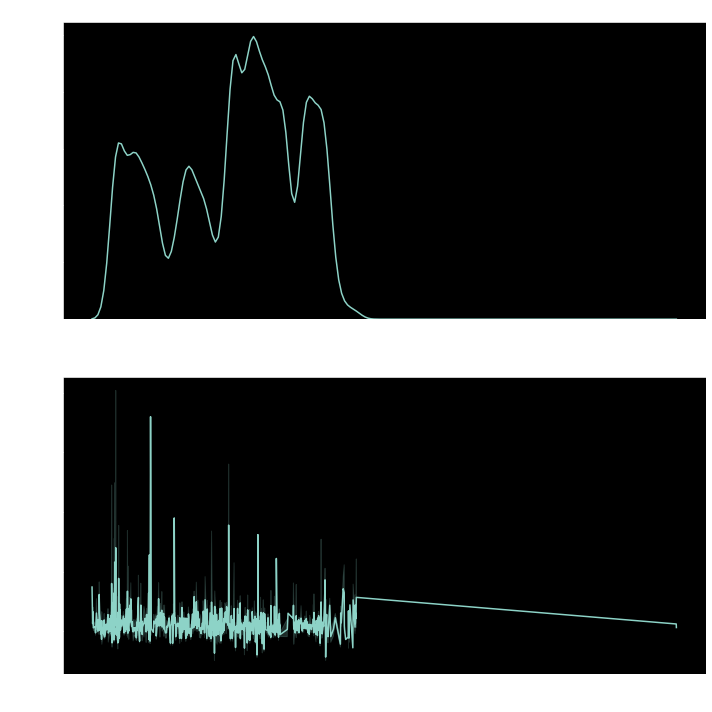

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].set_title('Flight Number Distribution')
axes[1].set_title('Flight Number - Arrival Delays')
sns.kdeplot(ax=axes[0], data=data, x='FlightNum')
sns.lineplot(ax=axes[1], data=data, x='FlightNum', y='ArrDelay')
plt.tight_layout()
plt.show()

#### Delay Distribution
##### Delays follow a typical Gaussian distribution

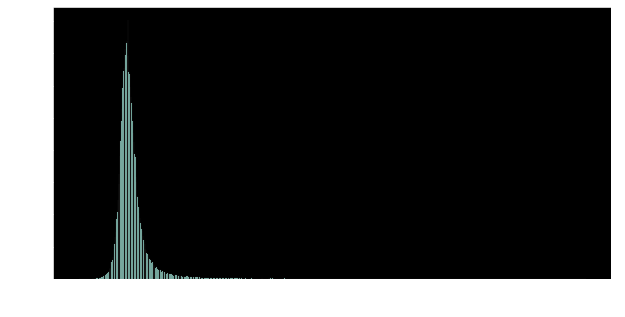

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='ArrDelay')
plt.show()

#### Origin airport distribution and delays
##### First plot: the origin data follow a distribution similar to the lognormal
##### Second plot: origin airports which show the greatest spikes in delays should be further analyzed in conjuction with the rest of the features associated with them.

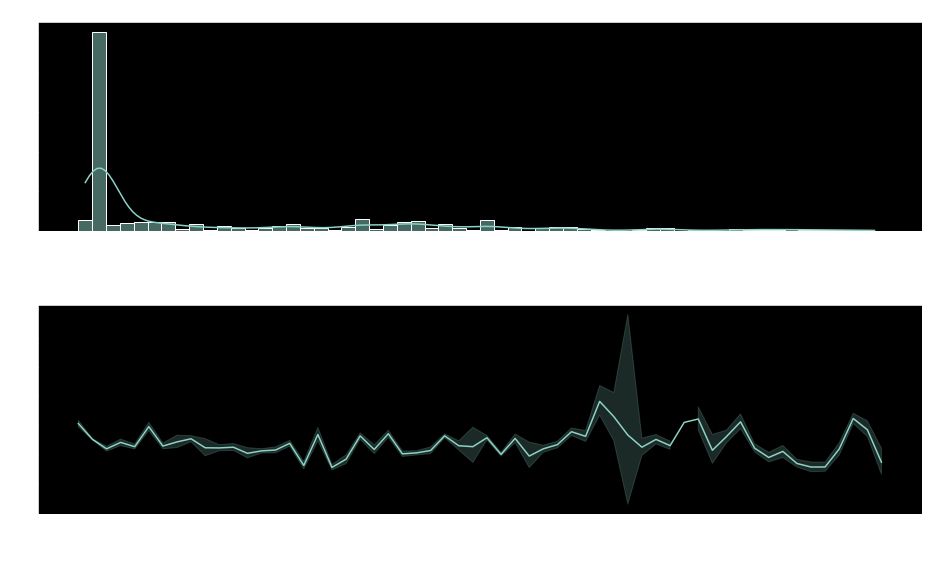

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8))
for ax in axes:
    ax.tick_params(rotation=90)

axes[0].set_title('Origin Airport Distribution')
axes[1].set_title('Origin Airport - Arrival Delays')
sns.histplot(ax=axes[0], x=data['Origin'], kde=True)
sns.lineplot(ax=axes[1], data=data, x='Origin', y='ArrDelay')

plt.tight_layout()
plt.show()

#### Destination distribution and delays

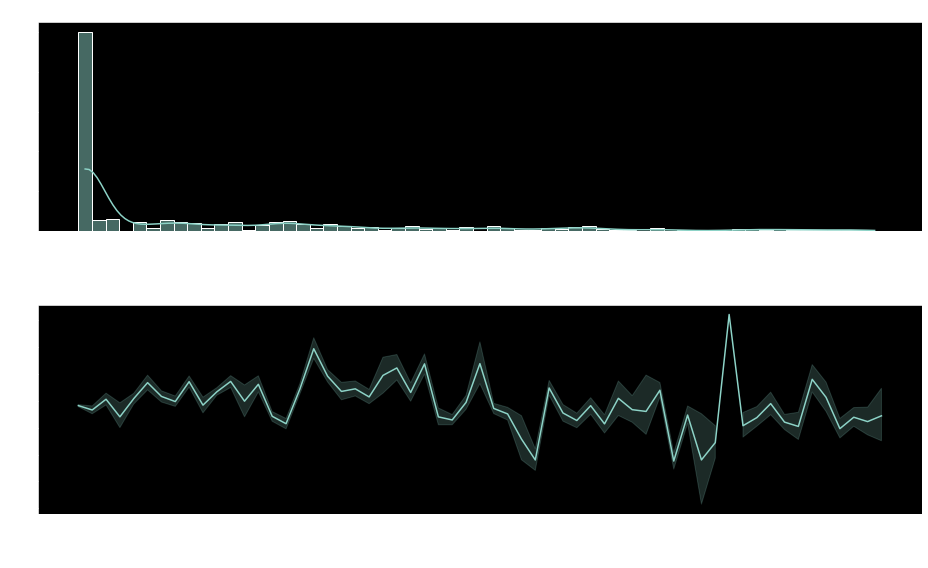

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8))
for ax in axes:
    ax.tick_params(rotation=90)

axes[0].set_title('Destination Airport Distribution')
axes[1].set_title('Destination Airport - Arrival Delays')
sns.histplot(ax=axes[0], x=data['Dest'], kde=True)
sns.lineplot(ax=axes[1], data=data, x='Dest', y='ArrDelay')

plt.tight_layout()
plt.show()

#### Airline company distribution and delays

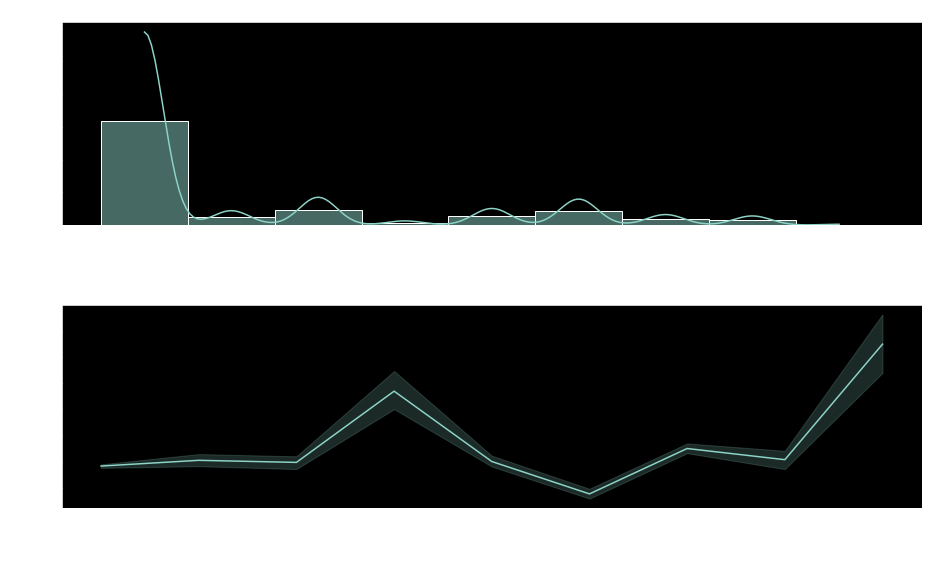

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(13, 8))
for ax in axes:
    ax.tick_params(rotation=45)

axes[0].set_title('Airline Distribution')
axes[1].set_title('Airline - Arrival Delays')
sns.histplot(ax=axes[0], x=data['UniqueCarrier'], kde=True)
sns.lineplot(ax=axes[1], data=data, x='UniqueCarrier', y='ArrDelay')

plt.tight_layout()
plt.show()

#### Distribution of delays per airline

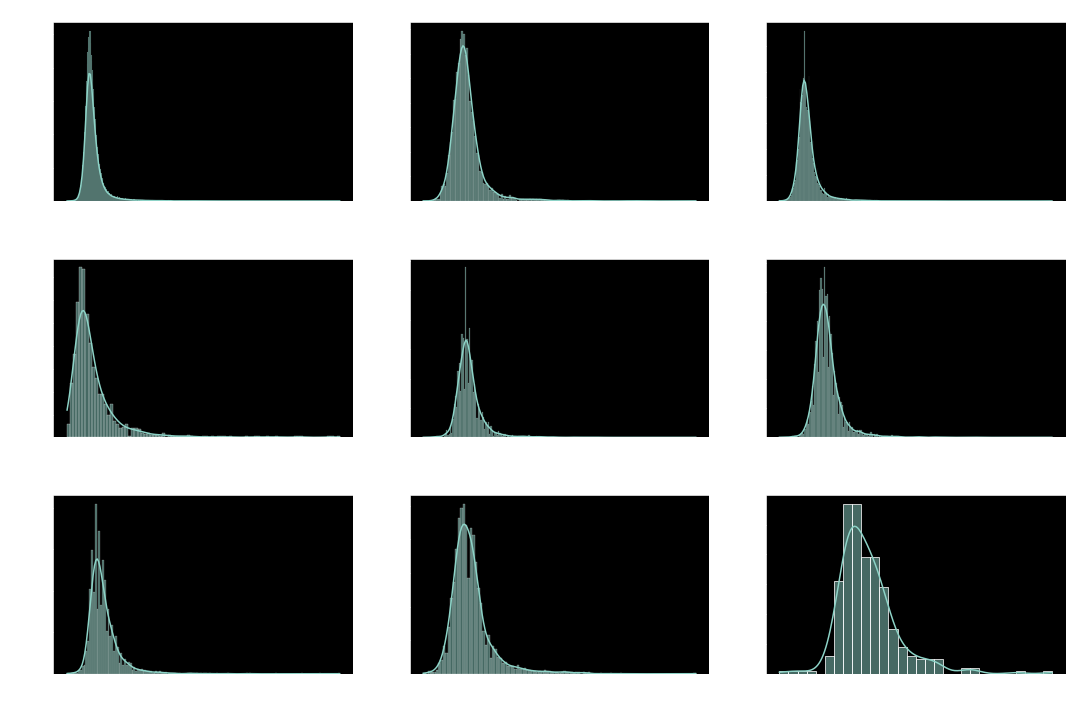

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
carriers = data['UniqueCarrier'].unique()
idx = 0
for i in range(3):
    for j in range(3):
        axes[i][j].set_title(carriers[idx])
        axes[i][j].set_xlabel('Arrival Delay')
        sns.histplot(x=data[data['UniqueCarrier'] == carriers[idx]]['ArrDelay'], ax=axes[i][j], kde=True)
        idx += 1
plt.tight_layout()
plt.show()

### Average delays per airline
##### First plot: airlines whose distributions are centered around zero and are more bell shaped are described better by calculating the mean of the associated delays.
##### Second plot: the airlines which have skewed distributions are better represented by the median, rather than the mean.

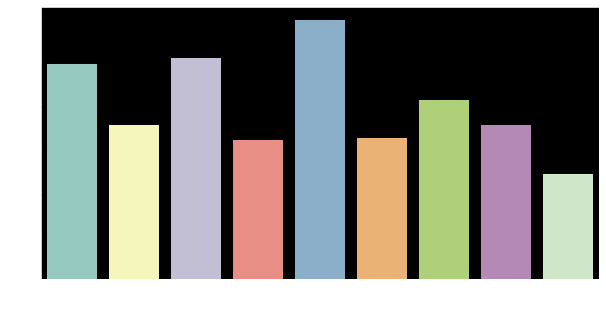

In [18]:
def barplot_avg(data, xlabel, ylabel='ArrDelay', rotation=0, width=10, height=5):
    """
        Description: Plot the average delay
    """
    delays = data.groupby(xlabel, as_index=False)[ylabel].mean()
    delays = pd.DataFrame(delays)
    plt.figure(figsize=(width, height))
    plt.xticks(rotation=rotation)
    sns.barplot(data=delays, x=xlabel, y=ylabel)
    plt.show()

non_negative = data.loc[data['ArrDelay'] > 0]
barplot_avg(non_negative, xlabel='UniqueCarrier')

### Average delays per origin airport.

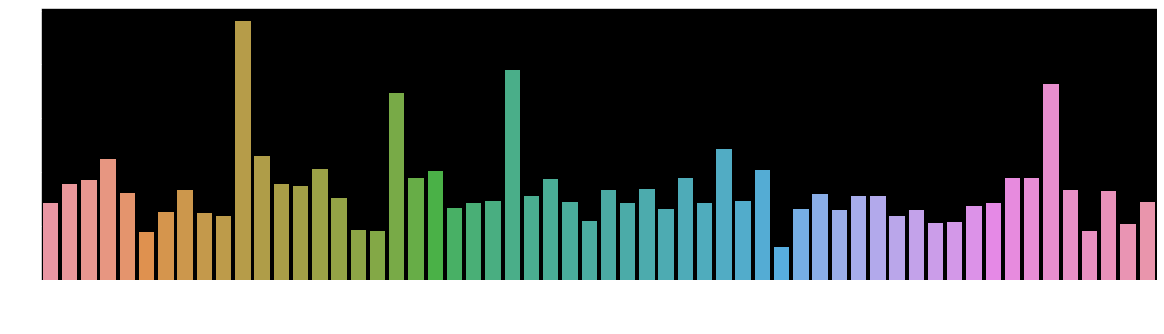

In [19]:
barplot_avg(non_negative, xlabel='Origin', rotation=45, width=20)

### Average delays per destination airport.

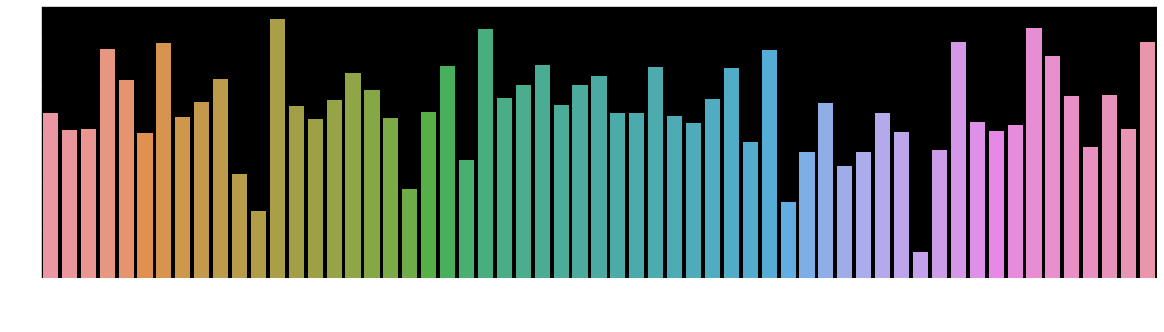

In [20]:
barplot_avg(non_negative, xlabel='Dest', rotation=45, width=20)

## Data Encoding & Class Distribution Visualization
#### Encoding has been applied using the BinaryEncoder to turn categorical features into binary representations.
#### Using a pie plot, the distribution of features has been displayed, illustrating that there is no significant class imbalance.

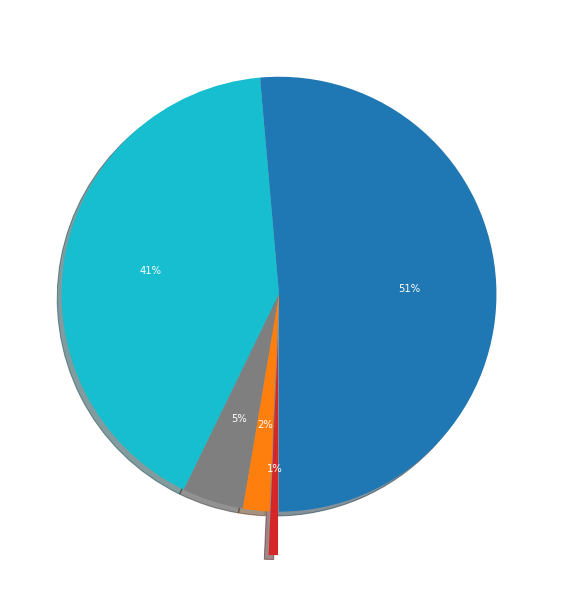

In [21]:
from sklearn.model_selection import KFold

import category_encoders as ce

def create_mult_class(x):
    # No delay
    if x <= 0:
        return 0
    # Short delay
    elif x > 0 and x <= 30:
        return 1
    # Medium Delay
    elif x > 30 and x <= 60:
        return 2
    # Large delay
    elif x > 60 and x <= 120:
        return 3
    # Extreme delay
    else:
        return 4

# Initialize the encoder with the appropriate feature names
encoder = ce.BinaryEncoder(cols=['UniqueCarrier', 'Origin', 'Dest'])
# Encode categorical data as binary numbers so the models can handle them
encoded_data = encoder.fit_transform(data[['UniqueCarrier', 'Origin', 'Dest']])

# Isolate the target variable
y = data['ArrDelay'].apply(create_mult_class)

X = data.loc[:, data.columns != 'ArrDelay']
# Drop the unused and categorical features
X.drop(columns=['DayofWeek', 'UniqueCarrier', 'Origin', 'Dest'], inplace=True)
# Merge the dataframe with the encoded columns
X = pd.concat([X, encoded_data], axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Class Distribution')
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']
xx = y.value_counts()
explode = [0, 0, 0, 0, 0.2]
ax.pie(xx, autopct='%.0f%%', explode=explode, colors=colors, shadow=True, labels=['No delay', 'Short', 'Medium', 'Large', 'Extreme'], startangle=270)
plt.show()

### Oversampling (SMOTE)

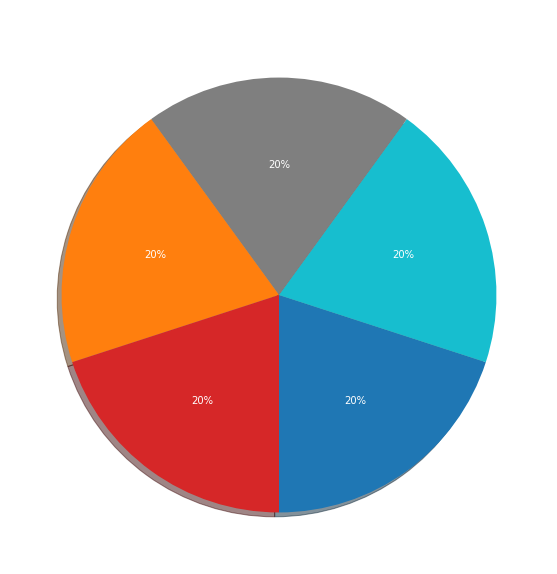

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Oversampling - Class Distribution')
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']
xx = y.value_counts()
ax.pie(xx, autopct='%.0f%%', colors=colors, shadow=True, labels=['No delay', 'Short', 'Medium', 'Large', 'Extreme'], startangle=270)
plt.show()

### Standarize the dataset

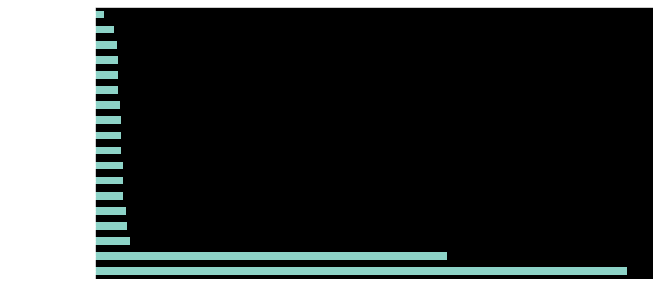

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

scaler = StandardScaler()
X[['CRSDepTime', 'FlightNum']] = scaler.fit_transform(X[['CRSDepTime', 'FlightNum']])

model = ExtraTreesClassifier(n_jobs=-1)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 5))
feature_importance.nlargest(len(X.columns)).plot(kind='barh')
plt.show()

X = X.drop(columns=['Dest_0', 'UniqueCarrier_0', 'Origin_0'])

Base model: RF --> scored: 0.5936848376526662
Base model: Ada-Boost --> scored: 0.342361839634249
Base model: GNB --> scored: 0.30926292885728723

Best base model: RF --> best score: 0.5936848376526662


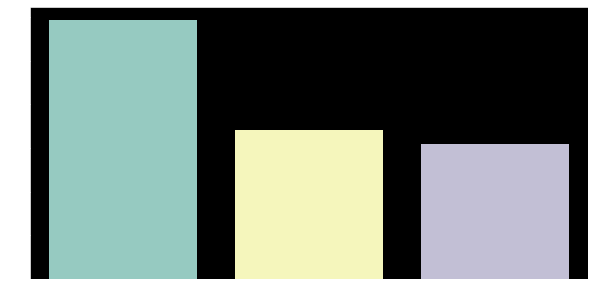

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.naive_bayes import GaussianNB

models = {
    'RF': RandomForestClassifier(),
    'Ada-Boost': AdaBoostClassifier(),
    'GNB': GaussianNB()
}

best_base_score = 0
best_base_model = None
scores = []
names = []
for name in models.keys():
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    score = cross_val_score(models[name], X, y, scoring='accuracy', cv=cv, n_jobs=-1).mean()
    scores.append(score)
    names.append(name)
    if score > best_base_score:
        best_base_score = score
        best_base_model = name
    print("Base model: {} --> scored: {}".format(name, score))
print('\nBest base model: {} --> best score: {}'.format(best_base_model, best_base_score))

plt.figure(figsize=(10, 5))
sns.barplot(x=names, y=scores)
plt.show()

## Frequent Itemsets & Rules

In [25]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

def change_format(x):
    return 0 if x == False else 1

def encode_as_transactions(data, columns):
    # Extract a subset of the data
    # to search for rules.
    data_copy = data[columns]

    for column in columns:
        data_copy[column] = data_copy[column].astype(str)

    # The apriori function requires a 2D list.
    data_copy = data_copy.values.tolist()

    encoder = TransactionEncoder()
    encoded_data = encoder.fit(data_copy).transform(data_copy)
    encoded_data = pd.DataFrame(encoded_data, columns=encoder.columns_)
    encoded_data = encoded_data.applymap(change_format)

    return encoded_data

def to_string(x):
    if x == 0:
        return 'No Delay'
    elif x == 1:
        return 'Short Delay'
    elif x == 2:
        return 'Medium Delay'
    elif x == 3:
        return 'Large Delay'
    else:
        return 'Extreme Delay'
    
non_negative['ArrDelay'] = non_negative['ArrDelay'].apply(create_mult_class)
non_negative['ArrDelay'] = non_negative['ArrDelay'].apply(to_string)

## Origin - Delay Rules

In [26]:
encoded_data = encode_as_transactions(non_negative, ['Origin', 'ArrDelay'])
frequent_itemsets = apriori(encoded_data, min_support=0.02, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules.loc[rules['antecedents'].apply(lambda a: len(next(iter(a))) == 3)].sort_values('confidence', ascending=False)

/home/nik/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
9,(PIT),(Short Delay),0.020211,0.921348,1.081768
0,(ATL),(Short Delay),0.029597,0.896702,1.052831
7,(LAX),(Short Delay),0.020806,0.885490,1.039666
5,(IAD),(Short Delay),0.435886,0.837920,0.983814
1,(BOS),(Short Delay),0.020683,0.818699,0.961246
2,(DEN),(Short Delay),0.023764,0.798482,0.937509
8,(ORD),(Short Delay),0.023908,0.762279,0.895003


## Destination - Delay Rules

In [27]:
encoded_data = encode_as_transactions(non_negative, ['Dest', 'ArrDelay'])
frequent_itemsets = apriori(encoded_data, min_support=0.02, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules.loc[rules['antecedents'].apply(lambda a: len(next(iter(a))) == 3)].sort_values('confidence', ascending=False)

/home/nik/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
6,(PIT),(Short Delay),0.022675,0.938776,1.102230
4,(LGA),(Short Delay),0.020478,0.866957,1.017906
3,(IAD),(Short Delay),0.415819,0.866652,1.017549
0,(ATL),(Short Delay),0.022819,0.854615,1.003416
2,(EWR),(Short Delay),0.020334,0.843990,0.990941
5,(ORD),(Short Delay),0.022100,0.817008,0.959261
1,(DEN),(Short Delay),0.021340,0.728101,0.854874


## Origin & Destination - Delay Rules

In [28]:
encoded_data = encode_as_transactions(non_negative, ['Dest', 'Origin', 'ArrDelay'])
frequent_itemsets = apriori(encoded_data, min_support=0.02, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

# Keep only the instances with 2 antecedents.
rules = rules.loc[rules['antecedents'].apply(lambda a: len(a) == 2)]
# Keep only the instances with 1 consequent.
rules = rules.loc[rules['consequents'].apply(lambda c: len(c) == 1)]
# Keep the consequents that are delays.
rules = rules.loc[rules['consequents'].apply(lambda c: 'Delay' in next(iter(c)))].sort_values('confidence', ascending=False)
# The filtered rules are 
# only those points of origin 
# and destination which 
# lead to delays.
rules

/home/nik/.local/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
72,"(IAD, PIT)",(Short Delay),0.042886,0.930481,1.092491
75,"(ROC, IAD)",(Short Delay),0.020170,0.929044,1.090804
39,"(IAD, BDL)",(Short Delay),0.035636,0.891115,1.046270
36,"(IAD, ATL)",(Short Delay),0.052416,0.877881,1.030733
45,"(CLE, IAD)",(Short Delay),0.023435,0.870328,1.021865
54,"(IAD, DTW)",(Short Delay),0.034260,0.865594,1.016307
63,"(LGA, IAD)",(Short Delay),0.037238,0.859649,1.009326
66,"(IAD, MCO)",(Short Delay),0.032452,0.853593,1.002215
51,"(IAD, DFW)",(Short Delay),0.031857,0.845692,0.992940
57,"(EWR, IAD)",(Short Delay),0.034136,0.842372,0.989041


## Expected Delays

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.preprocessing import LabelEncoder

def bin_class(x):
    if x <= 0:
        return 0
    else:
        return 1

data_copy = data.copy()
label_encoder = LabelEncoder()
cat_labels = ['UniqueCarrier', 'Origin', 'Dest']

for label in cat_labels:
    # Encode attributes to become valid input for the model
    data_copy[label] = label_encoder.fit_transform(data_copy[label])

# Extract rules based on decision tree classification
def extract_patterns(data, X_columns, depth=3):
    X = data[X_columns]
    # Make delay column binary (delay-non delay)
    y = data_copy['ArrDelay'].apply(bin_class)
    tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    tree_clf.fit(X, y)
    # Extract rules as a single string
    rules = export_text(tree_clf, feature_names=X_columns)
    print(rules)

### Classification Rules

In [30]:
extract_patterns(data=data_copy, X_columns=['CRSDepTime', 'Origin', 'Dest', 'FlightNum', 'UniqueCarrier'])

|--- CRSDepTime <= 1443.50
|   |--- UniqueCarrier <= 7.50
|   |   |--- FlightNum <= 281.50
|   |   |   |--- class: 0
|   |   |--- FlightNum >  281.50
|   |   |   |--- class: 0
|   |--- UniqueCarrier >  7.50
|   |   |--- CRSDepTime <= 1232.50
|   |   |   |--- class: 1
|   |   |--- CRSDepTime >  1232.50
|   |   |   |--- class: 1
|--- CRSDepTime >  1443.50
|   |--- UniqueCarrier <= 2.50
|   |   |--- UniqueCarrier <= 0.50
|   |   |   |--- class: 1
|   |   |--- UniqueCarrier >  0.50
|   |   |   |--- class: 0
|   |--- UniqueCarrier >  2.50
|   |   |--- FlightNum <= 940.50
|   |   |   |--- class: 1
|   |   |--- FlightNum >  940.50
|   |   |   |--- class: 1

